## Hands On Bayesian Statistics with Python, PyMC3 & ArviZ

If you think Bayes’ theorem is counter-intuitive and Bayesian statistics, which builds upon Baye’s theorem, can be very hard to understand. I am with you.

There are countless reasons why we should learn Bayesian statistics, in particular, Bayesian statistics is emerging as a powerful framework to express and understand next-generation deep neural networks.

I believe that for the things we have to learn before we can do them, we learn by doing them. And nothing in life is so hard that we can’t make it easier by the way we take it.

So, this is my way of making it easier: Rather than too much of theories or terminologies at the beginning, let’s focus on the mechanics of Bayesian analysis, in particular, how to do Bayesian analysis and visualization with PyMC3 & ArviZ. Prior to memorizing the endless terminologies, we will code the solutions and visualize the results, and using the terminologies and theories to explain the models along the way.

PyMC3 is a Python library for probabilistic programming with a very simple and intuitive syntax. ArviZ, a Python library that works hand-in-hand with PyMC3 and can help us interpret and visualize posterior distributions.

And we will apply Bayesian methods to a practical problem, to show an end-to-end Bayesian analysis that move from framing the question to building models to eliciting prior probabilities to implementing in Python the final posterior distribution.
Before we start, let’s get some basic intuitions out of the way:

Bayesian models are also known as probabilistic models because they are built using probabilities. And Bayesian’s use probabilities as a tool to quantify uncertainty. Therefore, the answers we get are distributions not point estimates.


## Bayesian Approach Steps

Step 1: Establish a belief about the data, including Prior and Likelihood functions.
    
Step 2, Use the data and probability, in accordance with our belief of the data, to update our model, check that our model agrees with the original data.

Step 3, Update our view of the data based on our model.

## The data

Since I am interested in using machine learning for price optimization, I decide to apply Bayesian methods to a Spanish High Speed Rail tickets pricing data set that can be found here. Appreciate The Gurus team for scraping the data set.

In [1]:
from scipy import stats
import arviz as az
import numpy as np
import matplotlib.pyplot as plt
import pymc3 as pm
import seaborn as sns
import pandas as pd
from theano import shared
from sklearn import preprocessing

print('Running on PyMC3 v{}'.format(pm.__version__))

Running on PyMC3 v3.6


In [2]:
data = pd.read_csv('renfe.csv')
data.drop('Unnamed: 0', axis = 1, inplace=True)
data = data.sample(frac=0.01, random_state=99)
data.head(3)

,insert_date,origin,destination,start_date,end_date,train_type,price,train_class,fare
420104,2019-04-22 08:00:25,MADRID,SEVILLA,2019-04-28 08:30:00,2019-04-28 11:14:00,ALVIA,NaN,Turista,Flexible
431888,2019-04-22 10:03:24,MADRID,VALENCIA,2019-05-20 06:45:00,2019-05-20 08:38:00,AVE,21.95,Turista,Promo
791293,2019-04-25 19:19:46,MADRID,SEVILLA,2019-05-29 06:20:00,2019-05-29 09:16:00,AV City,38.55,Turista,Promo


In [3]:
data.isnull().sum()/len(data)

insert_date    0.000000
origin         0.000000
destination    0.000000
start_date     0.000000
end_date       0.000000
train_type     0.000000
price          0.119467
train_class    0.003993
fare           0.003993
dtype: float64

There are 12% of values in price column are missing, I decide to fill them with the mean of the respective fare types. Also fill the other two categorical columns with the most common values.

In [4]:
data['train_class'] = data['train_class'].fillna(data['train_class'].mode().iloc[0])
data['fare'] = data['fare'].fillna(data['fare'].mode().iloc[0])
data['price'] = data.groupby('fare').transform(lambda x: x.fillna(x.mean()))

## Gaussian Inferences

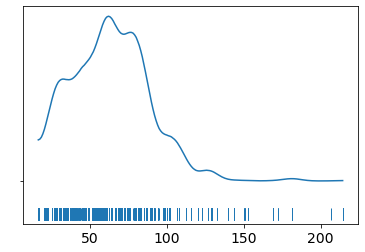

In [5]:
az.plot_kde(data['price'].values, rug=True)
plt.yticks([0], alpha=0);

The KDE plot of the rail ticket price shows a Gaussian-like distribution, except for about several dozens of data points that are far away from the mean.

Let’s assume that a Gaussian distribution is a proper description of the rail ticket price. Since we do not know the mean or the standard deviation, we must set priors for both of them. Therefore, a reasonable model could be as follows.



# Model


We will perform Gaussian inferences on the ticket price data. Here’s some of the modelling choices that go into this.

**We would instantiate the Models in PyMC3 like this:**

Model specifications in PyMC3 are wrapped in a with-statement.

**Choices of priors:**

- μ, mean of a population. Normal distribution, very wide. I do not know the possible values of μ, I can set priors reflecting my ignorance. From experience I know that train ticket price can not be lower than 0 or higher than 300, so I set the boundaries of the uniform distribution to be 0 and 300. You may have different experience and set the different boundaries. That is totally fine. And if you have more reliable prior information than I do, please use it!.

- σ, standard deviation of a population. Can only be positive, therefore use HalfNormal distribution. Again, very wide.

Choices for ticket price likelihood function:

- y is an observed variable representing the data that comes from a normal distribution with the parameters μ and σ.

- Draw 1000 posterior samples using NUTS sampling.

Using PyMC3, we can write the model as follows:


In [6]:
with pm.Model() as model_g:
    μ = pm.Uniform('μ', lower=0, upper=300)
    σ = pm.HalfNormal('σ', sd=10)
    y = pm.Normal('y', mu=μ, sd=σ, observed=data['price'].values)
    trace_g = pm.sample(1000, tune=1000)

AttributeError: module 'numpy.core.multiarray' has no attribute '_get_ndarray_c_version'

The y specifies the likelihood. This is the way in which we tell PyMC3 that we want to condition for the unknown on the knows (data).

We plot the gaussian model trace. This runs on a Theano graph under the hood.

In [23]:
az.plot_trace(trace_g);

NameError: name 'az' is not defined

- On the left, we have a KDE plot, — for each parameter value on the x-axis we get a probability on the y-axis that tells us how likely that parameter value is.


- On the right, we get the individual sampled values at each step during the sampling. From the trace plot, we can visually get the plausible values from the posterior.


- The above plot has one row for each parameter. For this model, the posterior is bi-dimensional, and so the above figure is showing the marginal distributions of each parameter.

There are a couple of things to notice here:

- Our sampling chains for the individual parameters (left) seem well converged and stationary (there are no large drifts or other odd patterns).

- The maximum posterior estimate of each variable (the peak in the left side distributions) is very close to the true parameters.
     
We can plot a joint distributions of parameters.


In [24]:
az.plot_joint(trace_g, kind='kde', fill_last=False);

NameError: name 'az' is not defined

I don’t see any correlation between these two parameters. This means we probably do not have collinearity in the model. This is good.


We can also have a detailed summary of the posterior distribution for each parameter.

In [25]:
az.summary(trace_g)

NameError: name 'az' is not defined

We can also see the above summary visually by generating a plot with the mean and Highest Posterior Density (HPD) of a distribution, and to interpret and report the results of a Bayesian inference.

In [27]:
az.plot_posterior(trace_g);

NameError: name 'az' is not defined

- Unlike Frequentist inference, in Bayesian inference, we get the entire distribution of the values.

- Every time ArviZ computes and reports a HPD, it will use, by default, a value of 94%.

- Please note that HPD intervals are not the same as confidence intervals. 

- Here we can interpret as such that there is 94% probability the belief is between 63.8 euro and 64.4 euro for the mean ticket price.

We can verify the convergence of the chains formally using the Gelman Rubin test. Values close to 1.0 mean convergence.

In [28]:
pm.gelman_rubin(trace_g)

NameError: name 'pm' is not defined

In [29]:
bfmi = pm.bfmi(trace_g)
max_gr = max(np.max(gr_stats) for gr_stats in pm.gelman_rubin(trace_g).values())
(pm.energyplot(trace_g, legend=False, figsize=(6, 4)).set_title("BFMI = {}\nGelman-Rubin = {}".format(bfmi, max_gr)));

NameError: name 'pm' is not defined

Our model has converged well and the Gelman-Rubin statistic looks fine.

## Posterior Predictive Checks

- Posterior predictive checks (PPCs) are a great way to validate a model. The idea is to generate data from the model using parameters from draws from the posterior.


- Now that we have computed the posterior, we are going to illustrate how to use the simulation results to derive predictions.


- The following function will randomly draw 1000 samples of parameters from the trace. Then, for each sample, it will draw 25798 random numbers from a normal distribution specified by the values of μ and σ in that sample.

In [30]:
ppc = pm.sample_posterior_predictive(trace_g, samples=1000, model=model_g)
np.asarray(ppc['y']).shape

NameError: name 'pm' is not defined

Now, ppc contains 1000 generated data sets (containing 25798 samples each), each using a different parameter setting from the posterior.

NameError: name 'ppc' is not defined

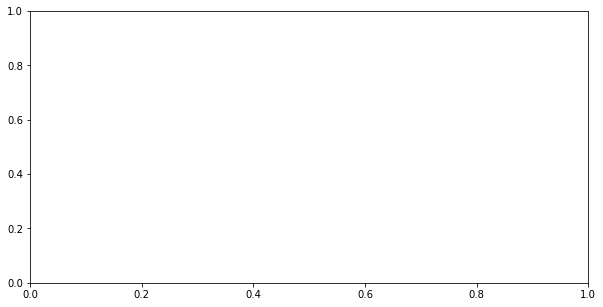

In [31]:
_, ax = plt.subplots(figsize=(10, 5))
ax.hist([y.mean() for y in ppc['y']], bins=19, alpha=0.5)
ax.axvline(data.price.mean())
ax.set(title='Posterior predictive of the mean', xlabel='mean(x)', ylabel='Frequency');

The inferred mean is very close to the actual rail ticket price mean.

## Group Comparison

We may be interested in how price compare under different fare types. We are going to focus on estimating the effect size, that is, quantifying the difference between two fare categories. To compare fare categories, we are going to use the mean of each fare type. Because we are Bayesian, we will work to obtain a posterior distribution of the differences of means between fare categories.

We create three variables:

- The price variable, representing the ticket price.

- The idx variable, a categorical dummy variable to encode the fare categories with numbers.

- And finally the groups variable, with the number of fare categories (6)

In [ ]:
price = data['price'].values
idx = pd.Categorical(data['fare'],
                     categories=['Flexible', 'Promo', 'Promo +', 'Adulto ida', 'Mesa', 'Individual-Flexible']).codes
groups = len(np.unique(idx))

The model for the group comparison problem is almost the same as the previous model. the only difference is that μ and σ are going to be vectors instead of scalar variables. This means that for the priors, we pass a shape argument and for the likelihood, we properly index the means and sd variables using the idx variable:

In [ ]:
with pm.Model() as comparing_groups:
    μ = pm.Normal('μ', mu=0, sd=10, shape=groups)
    σ = pm.HalfNormal('σ', sd=10, shape=groups)

    y = pm.Normal('y', mu=μ[idx], sd=σ[idx], observed=price)

    trace_groups = pm.sample(5000, tune=5000)

With 6 groups (fare categories), its a little hard to plot trace plot for μ and σ for every group. So, we create a summary table:

It is obvious that there are significant differences between groups (i.e. fare categories) on the mean.

To make it clearer, we plot the difference between each fare category without repeating the comparison.

- Cohen’s d is an appropriate effect size for the comparison between two means. Cohen’s d introduces the variability of each group by using their standard deviations.

- probability of superiority (ps) is defined as the probability that a data point taken at random from one group has a larger value than one taken at random from another group.

In [ ]:
dist = stats.norm()

_, ax = plt.subplots(5, 2, figsize=(20, 12), constrained_layout=True)

comparisons = [(i, j) for i in range(6) for j in range(i+1, 6)]
pos = [(k, l) for k in range(5) for l in (0, 1)]

for (i, j), (k, l) in zip(comparisons, pos):
    means_diff = trace_groups['μ'][:, i] - trace_groups['μ'][:, j]
    d_cohen = (means_diff / np.sqrt((trace_groups['σ'][:, i]**2 + trace_groups['σ'][:, j]**2) / 2)).mean()
    ps = dist.cdf(d_cohen/(2**0.5))
    az.plot_posterior(means_diff, ref_val=0, ax=ax[k, l])
    ax[k, l].set_title(f'$\mu_{i}-\mu_{j}$')
    ax[k, l].plot(
        0, label=f"Cohen's d = {d_cohen:.2f}\nProb sup = {ps:.2f}", alpha=0)
    ax[k, l].legend();

Basically, the above plot tells us that none of the above comparison cases where the 94% HPD includes the reference value of zero. This means for all the examples, we can rule out a difference of zero. The average differences range of 6.1 euro to 63.5 euro are large enough that it can justify for customers to purchase tickets according to different fare categories.

## Bayesian Hierarchical Linear Regression

We want to build a model to estimate the rail ticket price of each train type, and, at the same time, estimate the price of all the train types. This type of model is known as a hierarchical model or multilevel model.

- Encoding the categorical variable.

- The idx variable, a categorical dummy variable to encode the train types with numbers.
- And finally the groups variable, with the number of train types (16)

In [ ]:
def replace_fare(fare):
    
    if fare == 'Adulto ida':
        return 1
    elif fare == 'Promo +':
        return 2
    elif fare == 'Promo':
        return 3
    elif fare == 'Flexible':
        return 4
    elif fare == 'Individual-Flexible':
        return 5
    elif fare == 'Mesa':
        return 6

data['fare_encode'] = data['fare'].apply(lambda x: replace_fare(x))

label_encoder = preprocessing.LabelEncoder() 
data['train_type_encode']= label_encoder.fit_transform(data['train_type'])

train_type_names = data.train_type.unique()
train_type_idx = data.train_type_encode.values

n_train_types = len(data.train_type.unique())

data[['train_type', 'price', 'fare_encode']].head()

The relevant part of the data we will model looks as above. And we are interested in whether different train types affect the ticket price.

## Hierarchical Model

In [32]:
with pm.Model() as hierarchical_model:
    # global model parameters
    α_μ_tmp = pm.Normal('α_μ_tmp', mu=0., sd=100)
    α_σ_tmp = pm.HalfNormal('α_σ_tmp', 5.)
    β_μ = pm.Normal('β_μ', mu=0., sd=100)
    β_σ = pm.HalfNormal('β_σ', 5.)

    # train type specific model parameters
    α_tmp = pm.Normal('α_tmp', mu=α_μ_tmp, sd=α_σ_tmp, shape=n_train_types)  
    # Intercept for each train type, distributed around train type mean 
    β = pm.Normal('β', mu=β_μ, sd=β_σ, shape=n_train_types)
    # Model error
    eps = pm.HalfCauchy('eps', 5.)

    fare_est = α_tmp[train_type_idx] + β[train_type_idx]*data.fare_encode.values

    # Data likelihood
    fare_like = pm.Normal('fare_like', mu=fare_est, sd=eps, observed=data.price)
    
with hierarchical_model:
    hierarchical_trace = pm.sample(2000, tune=2000, target_accept=.9)
    
pm.traceplot(hierarchical_trace, var_names=['α_μ_tmp', 'β_μ', 'α_σ_tmp', 'β_σ', 'eps']);

NameError: name 'pm' is not defined

The marginal posteriors in the left column are highly informative, “α_μ_tmp” tells us the group mean price levels, “β_μ” tells us that purchasing fare category “Promo +” increases price significantly compare to fare type “Adulto ida”, and purchasing fare category “Promo” increases price significantly compare to fare type “Promo +”, and so on (no mass under zero).

In [34]:
pm.traceplot(hierarchical_trace, var_names=['α_tmp'], coords={'α_tmp_dim_0': range(5)});

NameError: name 'pm' is not defined

Among 16 train types, we may want to look at how 5 train types compare in terms of the ticket price. We can see by looking at the marginals for “α_tmp” that there is quite some difference in prices between train types; the different widths are related to how much confidence we have in each parameter estimate — the more measurements per train type, the higher our confidence will be.

Having uncertainty quantification of some of our estimates is one of the powerful things about Bayesian modelling. We’ve got a Bayesian credible interval for the price of different train types.

In [35]:
az.plot_forest(hierarchical_trace, var_names=['α_tmp', 'β'], combined=True);

NameError: name 'az' is not defined

Lastly, we may want to compute r squared:

In [36]:
ppc = pm.sample_posterior_predictive(hierarchical_trace, samples=2000, model=hierarchical_model)
az.r2_score(data.price.values, ppc['fare_like'])

NameError: name 'pm' is not defined

The objective of this post is to learn, practice and explain Bayesian, not to produce the best possible results from the data set. Otherwise, we would have gone with XGBoost directly.